# Import Data

In [2]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import pickle
import pandas as pd
import numpy as np
from psm_causal_effects import psm_causal_effects
from copy import deepcopy

# read data
with open('data.dat', 'rb') as f:
    data, subjects = pickle.load(f)
f.close()

# adding subject ids
for i in range(len(data)):
    data[i]['subject'] = pd.Series(np.repeat(subjects[i],data[i].shape[0],axis=0), index=data[i].index, dtype=str)

del subjects

# within subject normalization
datan = deepcopy(data)
for i in range(len(data)):
    datan[i]['mood'] = (data[i]['mood']-np.nanmean(data[i]['mood']))/np.nanstd(data[i]['mood'])
    datan[i]['mood_prev'] = (data[i]['mood_prev']-np.nanmean(data[i]['mood_prev']))/np.nanstd(data[i]['mood_prev'])
    datan[i]['quality'] = (data[i]['quality']-np.nanmean(data[i]['quality']))/np.nanstd(data[i]['quality'])
    
# concatenatig into a single dataframe
data_all = pd.concat(data, axis=0)
data_all = data_all.reset_index(drop=True)
datan_all = pd.concat(datan, axis=0)
datan_all = datan_all.reset_index(drop=True)

# keeping only relevant variables
data_all = data_all[['subject','mood','mood_prev','quality']]
datan_all = datan_all[['subject','mood','mood_prev','quality']]

# removing nan rows
data_all = data_all.dropna()
data_all = data_all.reset_index(drop=True)
datan_all = datan_all.dropna()
datan_all = datan_all.reset_index(drop=True)

# Calculate Personal Models Params.

In [3]:
# calculating personal model parameters

betas_m2s = np.zeros([len(data),2])
betas_s2m = np.zeros([len(data),2])
for iSubj in range(len(data)):
    if data[iSubj].shape[0] ==0:
        betas_m2s[iSubj, :] = np.array([np.nan, np.nan])
        betas_s2m[iSubj, :] = np.array([np.nan, np.nan])
    else:
        md = smf.glm('quality ~ mood_prev', data[iSubj])
        mdf = md.fit()
        betas_m2s[iSubj, :] = mdf.params
        md = smf.glm('mood ~ quality', data[iSubj])
        mdf = md.fit()
        betas_s2m[iSubj, :] = mdf.params

# Plot pooled and individual models

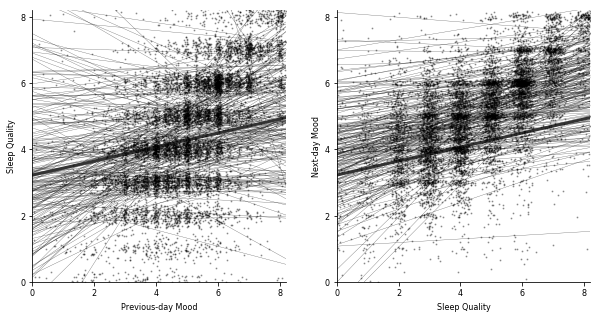

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

params = {'font.size' : 8,\
          'axes.labelsize' : 8,\
          'font.style' : 'normal',\
          'font.family' : 'sans-serif',\
        'font.sans-serif' : 'Arial'
}
plt.rcParams.update(params)



xmin= 0
xmax = 8.2
ymin = 0
ymax = 8.2

# Sleep on Mood
plt.figure(figsize=[10,5])
plt.subplot(121)
for iSubj in range(len(data)):
    plt.plot([xmin,xmax], [betas_m2s[iSubj, 0],betas_m2s[iSubj,0]+betas_m2s[iSubj,1]*xmax], color=(.1, .1,.1),linewidth=.3, alpha=.75)
plt.plot([xmin,xmax], [mdf.params[0],mdf.params[0]+mdf.params[1]*xmax], color=(.2, .2,.2), linewidth=3, alpha=1)
plt.plot(data_all['mood_prev']+0.075*np.random.randn(data_all.shape[0]),data_all['quality']+0.2*np.random.randn(data_all.shape[0]),'.',markersize=2,\
        color=(0,0,0),alpha=.3)
plt.xlabel('Previous-day Mood')
plt.ylabel('Sleep Quality')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

ax = plt.gca()
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(np.floor(xmin),np.ceil(xmax),2));
plt.yticks(np.arange(np.floor(ymin),np.ceil(ymax),2));


# Mood on sleep
plt.subplot(122)
for iSubj in range(len(data)):
    plt.plot([0,8.2], [betas_s2m[iSubj, 0],betas_s2m[iSubj,0]+betas_s2m[iSubj,1]*8.2], color=(.1, .1,.1), linewidth=.3, alpha=.75)
plt.plot([0,8.2], [mdf.params[0],mdf.params[0]+mdf.params[1]*8.2], color=(.2,.2,.2), linewidth=3)
plt.plot(data_all['quality']+0.2*np.random.randn(data_all.shape[0]),data_all['mood']+0.075*np.random.randn(data_all.shape[0]),'.',markersize=2,\
        color=(0,0,0),alpha=.3)
plt.xlabel('Sleep Quality')
plt.ylabel('Next-day Mood')
plt.xlim([0,8.2])
plt.ylim([0,8.2])

ax = plt.gca()
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));

#plt.text(xmax,ymax,'y = {:.2}x + {:.3}'.format(mdf.params[1],mdf.params[0]),fontsize=18)
plt.savefig('figures/Fig_2.eps', format='eps', dpi=1200)
plt.savefig('figures/Fig_2.tiff', format='tiff', dpi=1200) 
plt.savefig('figures/Fig_2_small.tiff', format='tiff') 

In [66]:
from scipy.stats.stats import pearsonr
rhos_m2s = np.zeros([len(data),2])
rhos_s2m = np.zeros([len(data),2])
for iSubj in range(len(data)):
    if data[iSubj].shape[0] ==0:
        rhos_m2s[iSubj, :] = np.array([np.nan, np.nan])
        rhos_s2m[iSubj, :] = np.array([np.nan, np.nan])
    else:
        na = np.logical_or(np.isnan(data[iSubj]['mood_prev']), np.isnan(data[iSubj]['quality']))
        md = data[iSubj]['mood_prev']
        sd = data[iSubj]['quality']
        rhos_m2s[iSubj, :] = pearsonr(md[~na],sd[~na])
        
        na = np.logical_or(np.isnan(data[iSubj]['mood']), np.isnan(data[iSubj]['quality']))
        md = data[iSubj]['mood']
        sd = data[iSubj]['quality']
        rhos_s2m[iSubj, :] = pearsonr(md[~na],sd[~na])

        
print(np.nanmean(rhos_m2s[:,0]), np.nanstd(rhos_m2s[:,0]))
print(np.nanmean(rhos_s2m[:,0]), np.nanstd(rhos_s2m[:,0]))

(0.13037246575041539, 0.22702506759548999)
(0.33945371542527081, 0.19926446889172764)
